<a href="https://colab.research.google.com/github/antonior92/advtrain-linreg/blob/main/notebooks/fig3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 200/200 [00:00<00:00, 883.66it/s]


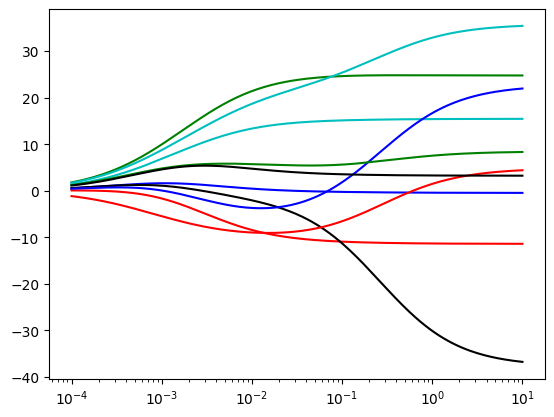

In [1]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
import tqdm
import cvxpy as cp
import numpy as np


def compute_q(p):
    if p != np.Inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.Inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, p):
        m, n = X.shape
        q = compute_q(p)
        # Formulate problem
        param = cp.Variable(n)
        param_norm = cp.pnorm(param, p=q)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False

    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, **kwargs)
            v = self.param.value
        except:
            v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    colors = cycle(["b", "r", "g", "c", "k"])
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    colors = cycle(["b", "r", "g", "c", "k"])
    l1norm = np.abs(coefs).mean(axis=0)
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)

X, y = datasets.load_diabetes(return_X_y=True)
# Standardize data
X -= X.mean(axis=0)
X /= X.std(axis=0)

fig, ax = plt.subplots(num='ridge')
estimator = lambda X, y, a: linear_model.Ridge(alpha=a, fit_intercept=False).fit(X, y).coef_
alphas_ridge, coefs_ridge = get_path(X, y, estimator, 1e4)
plot_coefs(alphas_ridge, coefs_ridge, ax)

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 200/200 [00:13<00:00, 15.10it/s]


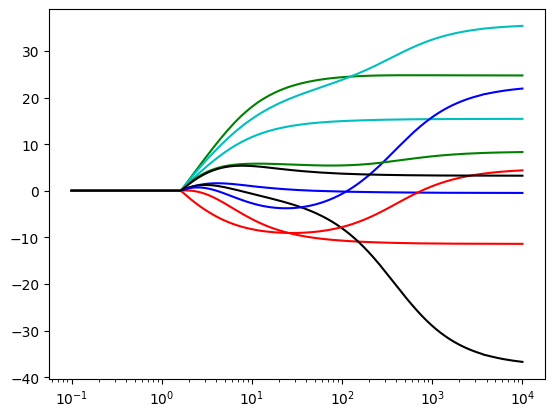

In [2]:
fig, ax = plt.subplots(num='advtrain_l2')
l2advtrain = AdversarialTraining(X, y, p=2)
estimator = lambda X, y, a:  l2advtrain(adv_radius=a)
alphas_adv, coefs_advtrain_l2 = get_path(X, y, estimator, 1e1)
plot_coefs(alphas_adv, coefs_advtrain_l2, ax)